# Project: Electric Vehicle Charging Scheduling Problem (EVCS)
## Final deliverable
## Prescriptive Analytics: Heuristics for Decision Making
### Wilmar Calderón - 201630701

The Electric Vehicle Charging Scheduling (EVCS) problems aims to determine the optimal sequence of charging $n$ vehicles in $m$ chargers. The EVCS can be formulated with multiple objectives as reducing cost or maximizing the charge, which are the most common objectives for the problem. This implementation describes a constructive Heuristic formulation to obtain an initial and feasible solution for the EVCS. The proposed implementation considers two approaches, first, the Earliest Departure First (EDF) and the First Come First Served (FCFS) approach. the former, prioritizes the vehicles that have the nearest departure time to schedule its charge first, the latter considers that the first vehcile that arrives should be attended. Implementation of the Heuristic is described below.

In [1]:
import json
import pandas as pd
from typing import Dict, Tuple
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import time

In [2]:
step=0.25 #Time spacing: Model parameter (value corresponds to fraction of an hour) 5% of 1 hour=3min

def time_to_index(t, delta_t=step):
    return int(t / delta_t)

def available_slots(initial,final):
    return range(initial,final+1)

#JSON File reader
#Input: Filepath
#Output: dict(Pandas Dataframes with the loaded information), int(number of parking spots), int(transformer limit)
def load_json_to_dfs(file_path: str) -> Tuple[Dict[str, pd.DataFrame], int, int]:
    with open(file_path, 'r') as file:
        data = json.load(file)
    dfs = {} #Dictionary where the dataframes will be sotred
    # Extracts the information in the JSON file of the filepath entered as parameter
    parking_config = data.get('parking_config', {})  #info related to the chargers
    n_spot = parking_config['n_spots'] #number of parking spots
    transformer_limit =parking_config['transformer_limit'] #Transformer limit

    dfs['energy_prices'] = pd.DataFrame(data['energy_prices'], columns=['time', 'price']) #Energy price dataframe

    dfs['arrivals'] = pd.DataFrame(data['arrivals'], columns=['id','arrival_time', 'departure_time', 'required_energy','brand','min_charge_rate',
                                                             'max_charge_rate','ac_charge_rate','dc_charge_rate','willingness_to_pay']) #Extraction of details of the attended EV
    dfs["arrivals"]["brand"]= dfs["arrivals"]["brand"].str.rsplit(' ').str[:-1].apply(' '.join)
    dfs["arrivals"]["arrival_slot"]=dfs["arrivals"]["arrival_time"].apply(time_to_index)
    dfs["arrivals"]["departure_slot"]=dfs["arrivals"]["departure_time"].apply(time_to_index)
    dfs["arrivals"]["available_slots"]=dfs["arrivals"].apply(lambda x: available_slots(x["arrival_slot"],x["departure_slot"]),axis=1)
    dfs['chargers'] = pd.DataFrame(parking_config['chargers'],columns=["charger_id","power","type","operation_cost_per_hour","compatible_vehicles"]) #Chargers Dataframe


    return dfs, n_spot, transformer_limit

In [3]:
#Function that creates the Gurobi model and calculates the performance metrics of the scheduling
def EVCS(dfs, n_spot, transformer_limit,inst): 
    time_i=time.time()
    #Datasets
    energy_p=dfs["energy_prices"]
    arrivals=dfs["arrivals"]
    chargers=dfs["chargers"]
    #Parameters

    lambda_c=max(energy_p["price"])*10 #penalty: defined as 10 times the most expensive kWh.

    #Related to the time period analyzed
    T_max=max(arrivals["departure_time"]) #Detail of the last departure
    T=list(np.round(np.arange(0,T_max+step,step),2)) #List of the time periods analyzed

    #Related to the EV arrivals
    N=arrivals["id"].tolist()
    n_ev=len(N)
    P_min=arrivals["min_charge_rate"].tolist()
    P_max=arrivals["max_charge_rate"].tolist()


    t_a = dict(zip(arrivals['id'], arrivals['arrival_time']))
    t_d = dict(zip(arrivals['id'], arrivals['departure_time']))
    e_req=dict(zip(arrivals['id'], arrivals['required_energy']))

    #Related to the chargers
    C = [x for x in chargers["charger_id"]]
    A = [[0 for _ in C] for _ in range(n_ev)]  # Not all EVs can access all chargers by default

    # If vehicle has restricted charger access
    for n, v in arrivals.iterrows():
        for c,charger in chargers.iterrows():
            if v["brand"] in charger["compatible_vehicles"]:
                A[n][c] =1

    charger_power = chargers.set_index('charger_id')['power'].to_dict() #P_c list


    M=chargers.shape[0] #M=Number of chargers

    #Related to the energy price
    energy_price_dict = dict(zip(energy_p['time'], energy_p['price']))
    energy_prices_df = pd.DataFrame(list(energy_price_dict.items()), columns=["time", "price"]).sort_values("time")
    T_df = pd.DataFrame({"time": list(T)}).sort_values("time")
    T_df = pd.merge_asof(T_df, energy_prices_df, on="time", direction="backward")
    e_t = dict(zip(T_df["time"].round(2), T_df["price"]))

    #Model definition

    from gurobipy import Model, GRB, quicksum
    model = gp.Model("ev_charging")

    # Variables
    P = model.addVars(N, T, name="P", lb=0.0) #Supply energy
    xi = model.addVars(N, C, T, vtype=GRB.BINARY, name="xi") #Binary variable to realte chargers, EV and time
    s = model.addVars(N, name="s", lb=0.0)  # Slack variable
    z = model.addVars(N, C, vtype=GRB.BINARY, name="z") #Binary variable to relate that the n-th EV is connected to charger c.

    #objective Function
    model.setObjective(quicksum(P[n, t] * e_t[t] for n in N for t in T)+ quicksum(lambda_c * s[n] for n in N),GRB.MINIMIZE)

    #Restriction 1
    # Limit of the number of chargers in the station
    for t in T:
        for c in C:
            model.addConstr(quicksum(xi[n, c, t] for n in N) <= M,name=f"charger_usage_limited_{c}_{t}")

    #Restriction 2
    # Charging station total energy should be less than transformer limit
    for t in T:
        model.addConstr(quicksum(P[n, t] for n in N) <= transformer_limit *step,name=f"transformer_limit_{t}")

    # Restriction 3
    # Charger Capacity and activation of the Energy supplied to vehicle n at time t (P[n,t]), and the variable 
    # xi to relate charger, vehicle and time
    for n in N:
        for t in T:
            model.addConstr(P[n, t] <= quicksum(xi[n, c, t] * charger_power[c] *step for c in C))


    #Restriction 4
    # Charging of the EV must be larger or equal to the requirement of the EV. 
    # This will consider that the variable s_n is activated as a slack variable to model that all EV's have been reviewed.
    for n in N:
        model.addConstr(quicksum(P[n, t] for t in T if t_a[n] <= t <= t_d[n])+ s[n] >= e_req[n],name=f"energy_requirement_{n}")

    #Restriction 5
    # Charging can only happen between the arrival and departure time.
    for t in T:
        for n in N:
            if not (t_a[n] <= t <= t_d[n]):
                model.addConstr(P[n, t] == 0, name=f"outside_time_{n}_{t}")

    
    #Restriction 6
    # The total chargers at each period of time should be maximum one (one charger per vehicle)
    for n in N:
        for c in C:
            for t in T:
                model.addConstr(xi[n, c, t] <= z[n, c])

    #Restriction 7
    # Only one charger per EV
    for n in N:
        model.addConstr(quicksum(z[n, c] for c in C) == 1)

    #Restriction 8
    # Chargers have determined compatibility with EV's. Chargers are matched with compatible cars.
    for t in T:
        for n in N:
            for c in C:
                model.addConstr(xi[n, c, t] <=A[n][c],name=f"charger_compatibility_{n}_{c}_{t}")

    #Restriction 9 & 10
    # The EV charging should be between the minimum and maximum energy supply rate.
    for n in N:    
        model.addConstr(quicksum(P[n, t] for t in T if t_a[n] <= t <= t_d[n]) >= P_min[n]*step,name=f"min_energy_EV_{n}")
        model.addConstr(quicksum(P[n, t] for t in T if t_a[n] <= t <= t_d[n]) <= P_max[n]*step,name=f"max_energy_EV_{n}")


    # Optimization
    model.setParam('OutputFlag', 0)
    model.setParam(GRB.Param.MIPGap, 1e-6) #Uncomment if you want to modify the gap. Lower gaps will require more processing
    model.optimize()


    if model.status == GRB.OPTIMAL:

        #Stores the charging sequence in an Excel File
        results = pd.DataFrame(index=T, columns=N)
        for n in N:
            for t in T:
                results.loc[t, n] = P[n, t].X if P[n, t].X > 0 else 0

        export_file="EVCP_MILP_instance_"+str(inst)+"_S01.xlsx"
        results.to_excel(export_file)

        kpi1=0 #Provided Total Energy
        kpi2=0 # Total Charging Cost
        kpi_l={} #Dict for the dissatisfied users to calculate KPI 3 and 4
        kpi_a={} #Dict for the dissatisfied users to calculate KPI 5 and 6
        admissible=0.5

        for n in N:
            e_req_n=e_req[n]
            aux=0 #auxilliary variable to get: sum(P_{n,t} if P_{n,t}>0)
            for t in T:
                if P[n, t].X > 0:
                    kpi1+=P[n, t].X
                    aux+=P[n, t].X
                    kpi2+=P[n, t].X*e_t[t]
            if aux>0:
                kpi_a[n]=aux
            if aux<e_req_n*admissible:
                kpi_l[n]=(e_req_n-aux)/e_req_n

        hours=14
        total_power_per_hour = []
        for i in range(1,hours+1,1):
            total_power=0
            for t in T:
                if i-1<t<=i:
                    total_power+=sum([P[n, t].X for n in N])
            total_power_per_hour.append(total_power)  

        diffs = [transformer_limit - hc for hc in total_power_per_hour]
        kpi8 = np.mean(total_power_per_hour)
        kpi9 = np.mean(diffs)
        kpi10 = np.std(diffs)
        
        kpi3=np.std(list(kpi_a.values()))
        kpi4=np.mean(list(kpi_a.values()))
        kpi5=min(list(kpi_a.values()))
        kpi6=len(kpi_l)
        kpi7=len(kpi_a)
        print("Objective value:", model.objVal)
        
        # print(kpi_a)
        # print(f'KPI 1 (Total Provided Energy): {kpi1}')
        # print(f'KPI 2 (Total Charging Cost): {kpi2}')
        # print(f'KPI 3 (Standard Deviation of Energy (KWh)): {kpi3}')
        # print(f'KPI 4 (Mean supplied energy (kWh)): {kpi4}')
        # print(f'KPI 5 (Minimum charge (kWh)): {kpi5}')
        # print(f'KPI 6 (Unsatisfied costumers): {kpi6}')
       
        # for t in T:
        #     for c in C:
        #         for n in N:
        #             if xi[n,c,t].X > 0 and P[n,t].X>0:
        #                 print(f"En el tiempo {t}, el cargador {c} está ocupado por el vehículo {n}")

        #KPI reporting
        results={"Instance:":inst,
                "Filename":export_file,
                "Number of Chargers":M,
                "Number of EV":len(N),
                "Requested Energy (kWh)":sum(e_req.values()),
                "Station Capacity":transformer_limit*T_max,
                "Provided Energy (kWh)":kpi1,
                "Provided/requested ratio (%)": kpi1/sum(e_req.values())*100,
                "Total Charging Cost ($)":kpi2,
                "Standard Deviation of Energy (KWh)":round(kpi3,3),
                "Mean supplied energy (kWh)":round(kpi4,3),
                "Minimum charge (kWh)":round(kpi5,2),
                "Satisfaction Threshold (%)":admissible,
                "Dissatisfied Users":kpi6,
                "Total attended users":kpi7,
                "Mean hourly charge":kpi8,
                "Mean difference to transformer limit":kpi9,
                "Std deviation of that difference":kpi10,
                "Total time (s)":time.time()-time_i
                }
        return results    



In [4]:
results=[]
for i in range (1,8):
    file_path = 'test_system_'+str(i)+'.json'
    dfs, n_spot, transformer_limit = load_json_to_dfs(file_path)
    res=EVCS(dfs, n_spot, transformer_limit,i)
    results.append(res)


summary_df=pd.DataFrame(results)
summary_df.to_excel("summary_EXACT_MILP_final_S01.xlsx")

Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-30
Objective value: 1229721.8554444513
Objective value: 1625910.6868475857
Objective value: 1656688.9119254325
Objective value: 1807462.5799603155
Objective value: 2573003.6484363764
Objective value: 2616605.68010653
Objective value: 3763721.656888725


In [5]:
i=1
filename="EVCP_MILP_instance_"+str(i)+".xlsx"
file_path = 'test_system_'+str(i)+'.json'
dfs, n_spot, transformer_limit = load_json_to_dfs(file_path)
df = pd.read_excel(filename)

# Set the time column
df = df.rename(columns={df.columns[0]: "Time"})
# Calculate total power per time step
df["TotalPower"] = df.drop(columns="Time").sum(axis=1)

C:\Users\wilma\AppData\Local\Temp\ipykernel_35908\3160587337.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  power_per_hour = total_power_per_timestep.groupby(binned).sum()


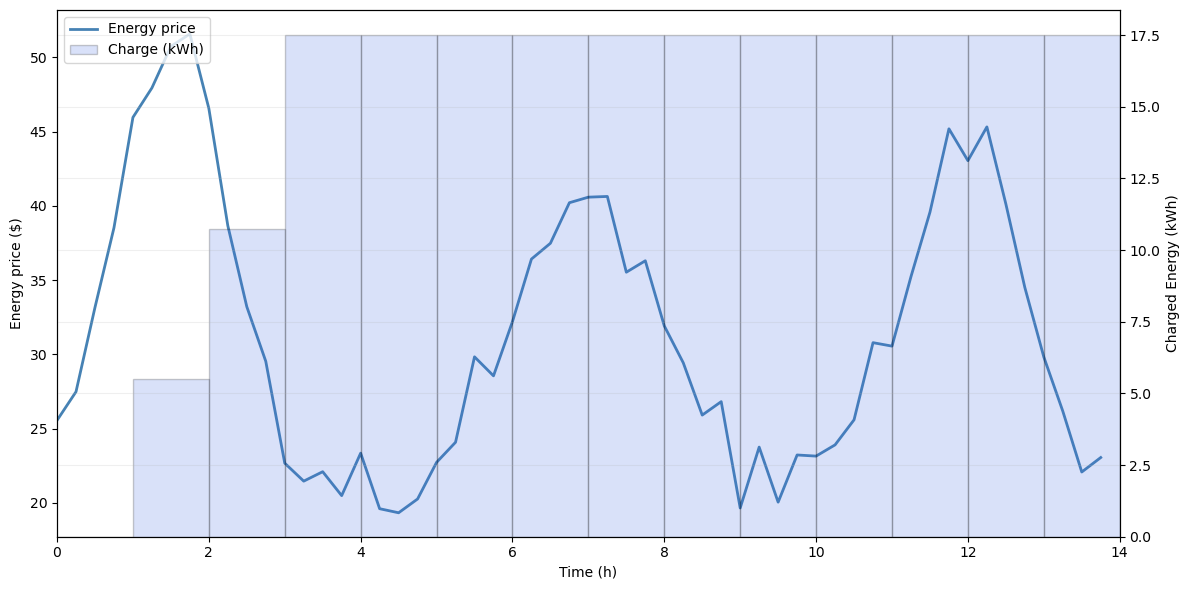

In [6]:
charging_p=df.copy().drop(columns=["Time","TotalPower"])

# Step 1: Make sure your index is float time values
time_index = charging_p.index.astype(float)

# Step 2: Total power across EVs at each timestep
total_power_per_timestep = charging_p.sum(axis=1)

# Step 3: Define hour bins
start = np.floor(time_index.min())
end = np.ceil(time_index.max())
bins = np.arange(start, end + 1, 1.0)

# Step 4: Cut into bins — use integer labels
binned = pd.cut(time_index, bins=bins, labels=bins[:-1].astype(int), right=False)

# Step 5: Group and sum
power_per_hour = total_power_per_timestep.groupby(binned).sum()

# Convert index to float so we can use it in bar plot
x = power_per_hour.index.astype(float)
y = power_per_hour.values

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Line (energy price)
line = ax1.plot(
    dfs["energy_prices"]["time"], 
    dfs["energy_prices"]["price"], 
    color="steelblue", 
    linewidth=2, 
    label="Energy price"
)

# Bar (charging energy)
bars = ax2.bar(
    x=x, 
    height=y, 
    width=1.0, 
    align='edge', 
    color='royalblue', 
    edgecolor='black', 
    alpha=0.2, 
    label="Charge (kWh)"
)

# Axis labels
ax1.set_xlabel("Time (h)")
ax1.set_xlim([0, 14])
ax1.set_ylabel("Energy price ($)")
ax2.set_ylabel("Charged Energy (kWh)")

# Combine legends from both axes
lines_labels = ax1.get_legend_handles_labels()
bars_labels = ax2.get_legend_handles_labels()
ax1.legend(lines_labels[0] + bars_labels[0], lines_labels[1] + bars_labels[1],loc="upper left")
plt.grid(True,alpha=0.2)
plt.tight_layout()
plt.show()

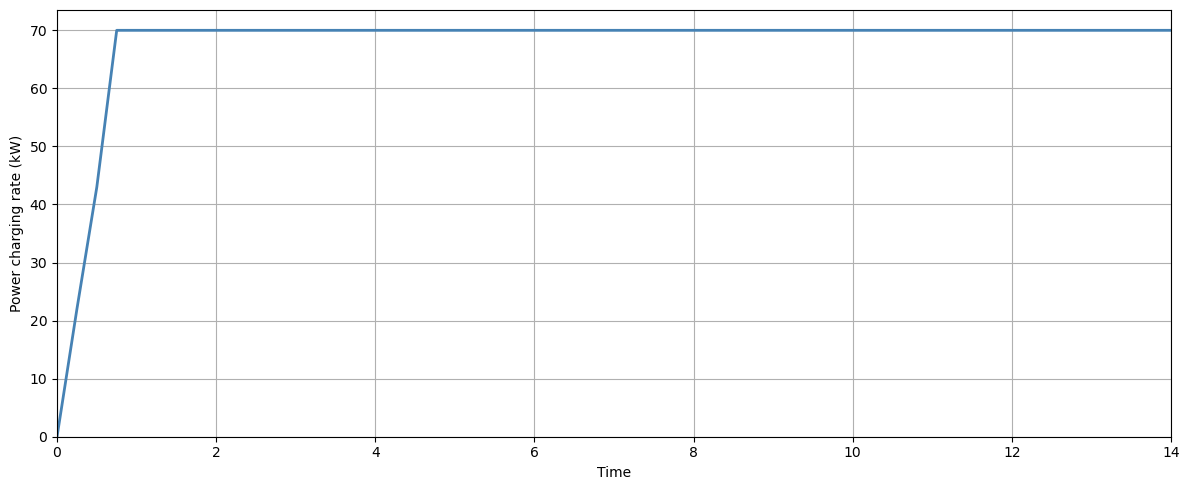

In [7]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(df["Time"], df["TotalPower"]/step, color="steelblue", linewidth=2)
# plt.title("Total power charged for the EV during the operation window", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Power charging rate (kW)")
plt.xlim([0,14])
plt.ylim(0)
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
session_df = dfs["arrivals"]

df=df.copy()
df.index=df["Time"]

charged_energy = df.drop(columns=["Time", "TotalPower"]).cumsum()

charging_prof=charged_energy.div(session_df["required_energy"])

charging_prof=charging_prof.T

C:\Users\wilma\AppData\Local\Temp\ipykernel_35908\3569150946.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("YlGn")


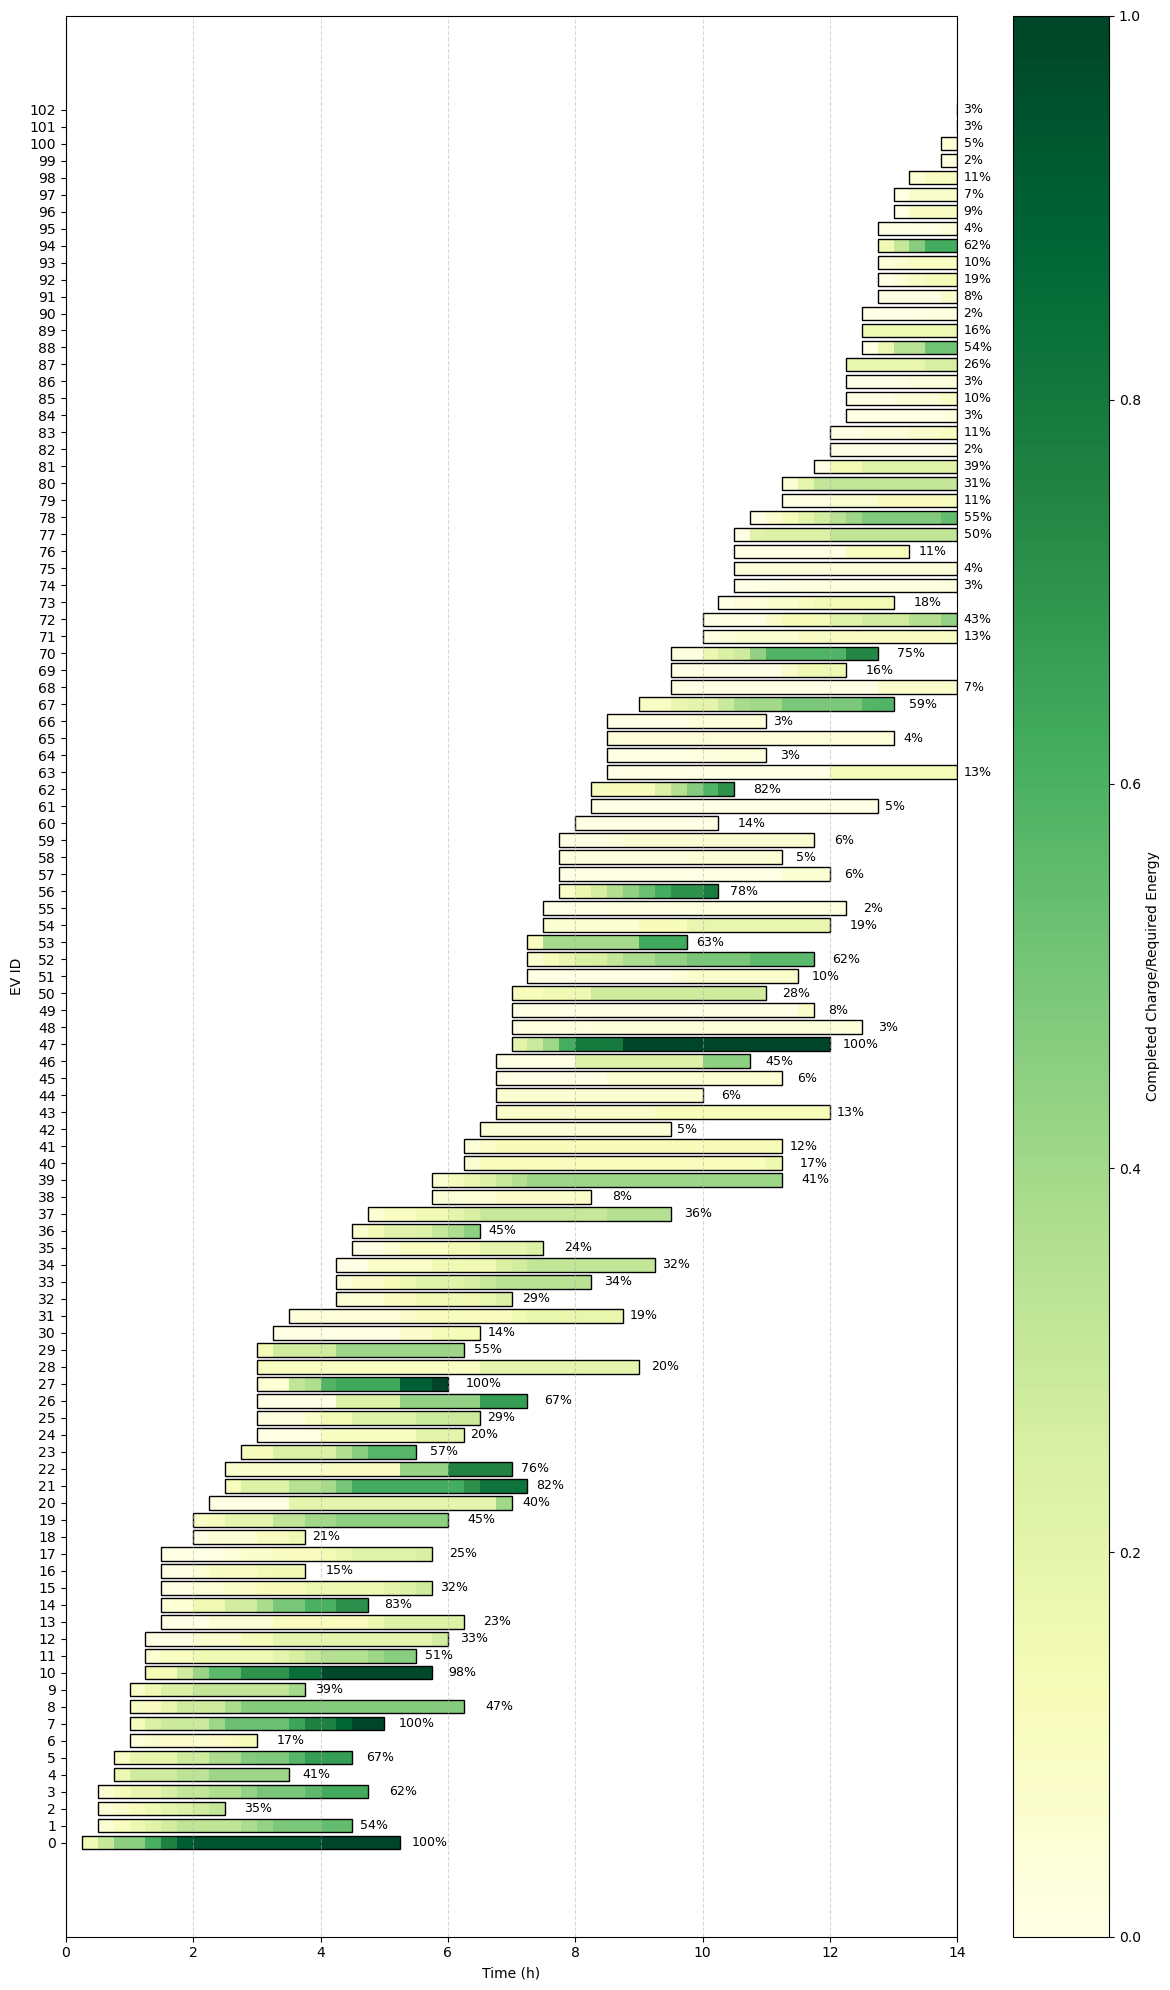

In [9]:
# Plot
fig, ax = plt.subplots(figsize=(12,20))
cmap = cm.get_cmap("YlGn")
norm = Normalize(vmin=0, vmax=1)

# Time Values
time_values = np.array([float(t) for t in charging_prof.columns])

# Loop through each EV
for i, row in charging_prof.iterrows():
    ev_id = str(i)
    arrival = session_df.loc[i, "arrival_time"]
    departure = session_df.loc[i, "departure_time"]

    # Extract power values as a NumPy array
    powers = row.values

    # Filter time window
    mask = (time_values >= arrival) & (time_values <= departure)
    times = time_values[mask]
    powers = powers[mask]

    # # Normalize power for color (or replace with cumulative energy/efficiency if preferred)
    colors = cmap(norm(powers))

    # Draw segments
    for j in range(len(times) - 1):
        ax.barh(
            y=ev_id,
            width=times[j+1] - times[j],
            left=times[j],
            height=0.8,
            color=colors[j],
            edgecolor="none"
        )
    ax.barh(
        y=ev_id,
        width=times[-1] - times[0],
        left=times[0],
        height=0.8,
        color="none",
        edgecolor="black"
    )
    percent = powers[-1] * 100

    # Add annotation
    ax.text(
        x=departure + 0.1,  # small offset to the right
        y=int(ev_id),
        s=f"{percent:.0f}%",
        va="center",
        ha="left",
        fontsize=9,
        color="black"
    )

ax.set_xlabel("Time (h)")
ax.set_ylabel("EV ID")
# ax.set_title("EV Charging Schedule")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)
ax.set_xlim([0,14])
# Step 5: Colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Completed Charge/Required Energy")
plt.tight_layout()
plt.show()